In [1]:
library(MatchIt)
library(survival)
library(survminer)
library(tidyr)
library(tableone)
library(plotRCS)
library(rms)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘plotRCS’


The following object is masked from ‘package:survival’:

    cancer


Loading required package: Hmisc


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units




In [2]:
df_survival <- read.csv("df_eicu_c3_riskfactor.csv",as.is = TRUE)
df_survival <- as.data.frame(df_survival)
#df_survival$groupHPD <- as.factor(df_survival$groupHPD)
df_select <-  df_survival#[df_survival$time==1,] # subset(df_survival, time == c(1))


# 单因素
- 单因素分析是指在一个时间点上，研究不同水平的某因素对一个独立变量变量的影响程度的分析

In [3]:
# # MIMIC
# 'los_sepsis_saaki',  'max_aki_stage_crea',
#        'max_aki_stage_uo', 'first_aki_stage', 'max_aki_stage', 'aki_endstage',
#        'aki_endstage_H7D',  
#        'gender', 'age', 'baseline_Scr', 'Peak_Scr', 'Discharge_Scr',
#        'Myocardial_infarct', 'Congestive_heart_failure',
#        'Peripheral_vascular_disease', 'Cerebrovascular_disease',
#        'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
#        'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
#        'Hypertension', 'Respiratory_failure', 'Septic_shock', 'is_vaso',
#        'is_mv', 'is_rrt', 'is_crrt'
# # AUMC
# 'los_sepsis_saaki',  'icu_stay_days', 'gender',
#        'age', 'weight', 'first_aki_stage', 'max_aki_stage', 'aki_endstage',
#        'aki_endstage_H7D', 'max_aki_stage_crea', 'max_aki_stage_uo', 'is_vaso',
#        'is_mv', 'is_rrt','baseline_Scr', 'Peak_Scr', 'Discharge_Scr'

# eICU
# 'los_sepsis_saaki', 'age',
#        'height', 'weight', 'icu_stay_days', 'first_aki_stage', 'max_aki_stage',
#        'aki_endstage', 'aki_endstage_H7D', 'max_aki_stage_crea',
#        'max_aki_stage_uo', 'baseline_Scr', 'Peak_Scr', 'Discharge_Scr',
#        'is_vaso', 'is_mv', 'is_rrt', 'Acidosis', 'Cardiogenic_shock',
#        'Congestive_heart_failure', 'Diabetes', 'Hepatic', 'Hypertension',
#        'Hypovolemic_shock', 'Myocardial_infarct', 'Respiratory_failure',
#        'Septic_shock', 'cardiovascular', 'gastrointestinal', 'neurologic',
#        'oncology', 'pulmonary', 'renal'

In [4]:
# 协变量设定：
covariates <- c('los_sepsis_saaki', 'age',
       'height', 'weight', 'icu_stay_days', 'first_aki_stage', 'max_aki_stage',
       'aki_endstage', 'aki_endstage_H7D', 'max_aki_stage_crea',
       'max_aki_stage_uo', 'baseline_Scr', 'Peak_Scr', 'Discharge_Scr',
       'is_vaso', 'is_mv', 'is_rrt', 'Acidosis', 'Cardiogenic_shock',
       'Congestive_heart_failure', 'Diabetes', 'Hepatic', 'Hypertension',
       'Hypovolemic_shock', 'Myocardial_infarct', 'Respiratory_failure',
       'Septic_shock', 'cardiovascular', 'gastrointestinal', 'neurologic',
       'oncology', 'pulmonary', 'renal')

# 得到一个列表分别为，对每个变量构建的生存对象公式
univ_formulas <- sapply(covariates,function(x) as.formula(paste('Surv(survival_28day, mortality_28d)~', x)))

univ_models <- lapply( univ_formulas, function(x){coxph(x, data = df_select)})

# 结果总和
univ_results <- lapply(univ_models,
                       function(x){ 
                          x <- summary(x)
                          p.value<-signif(x$wald["pvalue"], digits=2)
                          wald.test<-signif(x$wald["test"], digits=2)
                          beta<-signif(x$coef[1], digits=2);#coeficient beta
                          HR <-signif(x$coef[2], digits=2);#exp(beta)
                          HR.confint.lower <- signif(x$conf.int[,"lower .95"],2)
                          HR.confint.upper <- signif(x$conf.int[,"upper .95"],2)
                          HR <- paste0(HR, " (", 
                                       HR.confint.lower, "-", HR.confint.upper, ")")
                          res<-c(beta, HR, wald.test, p.value)
                          names(res)<-c("beta", "HR (95% CI for HR)","wald.test", "p.value")
                          return(res)
                          #return(exp(cbind(coef(x),confint(x))))
                         })
res <- t(as.data.frame(univ_results, check.names = FALSE))
res <- as.data.frame(res)
res

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”


,beta,HR (95% CI for HR),wald.test,p.value
,<chr>,<chr>,<chr>,<chr>
los_sepsis_saaki,-0.00071,1 (0.99-1),0.03,0.87
age,0.021,1 (1-1),6.1,0.014
height,-0.015,0.99 (0.97-1),2.1,0.14
weight,-0.0079,0.99 (0.98-1),3.2,0.075
icu_stay_days,-0.084,0.92 (0.87-0.97),8.9,0.0028
first_aki_stage,0.044,1 (0.7-1.6),0.05,0.83
max_aki_stage,0.0052,1 (0.75-1.4),0,0.97
aki_endstage,0.54,1.7 (1.3-2.2),15,9e-05
aki_endstage_H7D,0.84,2.3 (1.8-3),38,6e-10


## p值为0.05 筛选协变量

In [5]:
res$p.value <- as.numeric(res$p.value)
print(paste0("总变量数：",dim(res)[1]))
print(paste0("p值筛选后的变量数：",dim(res[res$p.value < 0.05,])[1]))

resstr <- paste(rownames(res[res$p.value < 0.05,]), collapse = " + ")
resstr <- paste("Surv(survival_28day, mortality_28d) ~ +", resstr)
resstr

[1] "总变量数：33"
[1] "p值筛选后的变量数：5"


[1] "Surv(survival_28day, mortality_28d) ~ + age + icu_stay_days + aki_endstage + aki_endstage_H7D + is_vaso"

# 多因素
- 多因素分析是对一个独立变量是否受一个或多个因素或变量影响而进行的分析。

In [6]:
res.cox <- coxph(as.formula(resstr), data = df_select)
summary(res.cox)

Call:
coxph(formula = as.formula(resstr), data = df_select)

  n= 159, number of events= 57 
   (4 observations deleted due to missingness)

                      coef exp(coef)  se(coef)      z Pr(>|z|)   
age               0.018983  1.019164  0.008234  2.306  0.02113 * 
icu_stay_days    -0.084970  0.918540  0.032318 -2.629  0.00856 **
aki_endstage     -0.270304  0.763147  0.324842 -0.832  0.40535   
aki_endstage_H7D  0.943610  2.569240  0.314623  2.999  0.00271 **
is_vaso           0.920715  2.511086  0.289388  3.182  0.00146 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                 exp(coef) exp(-coef) lower .95 upper .95
age                 1.0192     0.9812    1.0028    1.0357
icu_stay_days       0.9185     1.0887    0.8622    0.9786
aki_endstage        0.7631     1.3104    0.4037    1.4425
aki_endstage_H7D    2.5692     0.3892    1.3867    4.7601
is_vaso             2.5111     0.3982    1.4241    4.4278

Concordance= 0.806  (se = 0.025 )
Likelihood r

In [7]:
# 整合结果
mul_cox <- summary(res.cox)
mul_HR<- round(mul_cox$coefficients[,2],2) 
mul_Pvalue<- mul_cox$coefficients[,5] #round(mul_cox$coefficients[,5],4) 
mul_CI5<-round(mul_cox$conf.int[,3],2)
mul_CI95<-round(mul_cox$conf.int[,4],2)
mul_CI<-paste0(mul_HR,' (',mul_CI5,'-',mul_CI95,')')
Variable<-row.names(data.frame(mul_cox$coefficients))
mulcox_res<- data.frame(Variable,mul_HR,mul_CI5,mul_CI95,mul_CI,mul_Pvalue)
colnames(mulcox_res)=c("Variable","HR","CI5","CI95","HR (95% CI)","Pvalue")
mulcox_res$Pvalue <- sapply(mulcox_res$Pvalue, function(x) sprintf("%.2e", x))
mulcox_res$Pvalue <- as.numeric(mulcox_res$Pvalue)
View(mulcox_res)

,Variable,HR,CI5,CI95,HR (95% CI),Pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
age,age,1.02,1.00,1.04,1.02 (1-1.04),0.02110
icu_stay_days,icu_stay_days,0.92,0.86,0.98,0.92 (0.86-0.98),0.00856
aki_endstage,aki_endstage,0.76,0.40,1.44,0.76 (0.4-1.44),0.40500
aki_endstage_H7D,aki_endstage_H7D,2.57,1.39,4.76,2.57 (1.39-4.76),0.00271
is_vaso,is_vaso,2.51,1.42,4.43,2.51 (1.42-4.43),0.00146


## p值为0.05 筛选协变量

In [8]:
print(paste0("总变量数：",dim(mulcox_res)[1]))
print(paste0("p值筛选后的变量数：",dim(mulcox_res[mulcox_res$Pvalue < 0.05,])[1]))
mulcox_res_filt <- mulcox_res[mulcox_res$Pvalue < 5e-2,]

paste(rownames(mulcox_res_filt), collapse = " + ")

[1] "总变量数：5"
[1] "p值筛选后的变量数：4"


[1] "age + icu_stay_days + aki_endstage_H7D + is_vaso"

In [9]:
rownames(mulcox_res_filt)

[1] "age"              "icu_stay_days"    "aki_endstage_H7D" "is_vaso"

# 结果plot 

## 森林图

Loading required package: grid

Loading required package: checkmate

Loading required package: abind



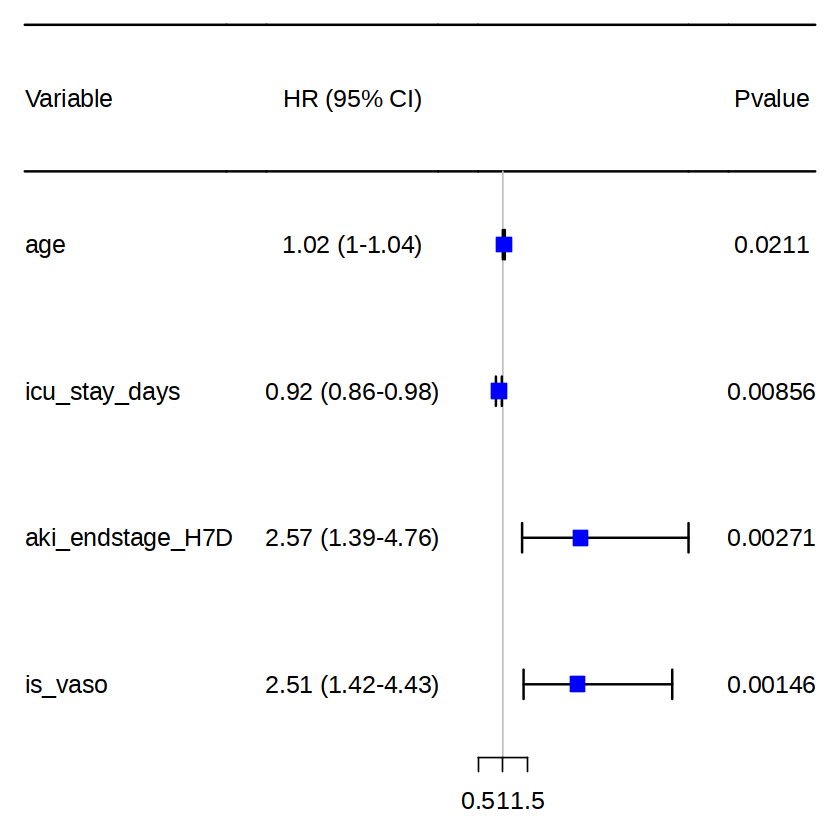

In [10]:
library(forestplot)
dat=rbind(c("Variable", NA,NA,NA,"HR (95% CI)", "Pvalue"),mulcox_res_filt)
forestplot(dat[,c(1,5,6)], #显示表格的第1，5，6列内容
           mean=dat[,2],   #第2列为HR，变成森林图的方块
           lower=dat[,3], upper=dat[,4], #第3列为5%CI，第4列为95%CI，将化作线段，穿过方块
           zero=1,            #零线或参考线位置为HR=1
           boxsize=0.1,       #设置方块大小
           graph.pos=3,#将森林图插在第3列
           xticks=c(0.5,1,1.5) ,# 设置横轴数字
           txt_gp=fpTxtGp (
             label=gpar(cex=1.2) ,ticks=gpar(cex=1.2)
            ),#调整字体
           hrzl_lines=list("1" = gpar(lty=1,lwd=1.5)
                           ,"2" = gpar(lty=1,lwd=1.5)
#                            ,"3"= gpar(lty=1,lwd=1.5)
                          ), # 在1,2,7行添加横线
           col=fpColors ( box = 'blue ' , #方块颜色 
                          lines = ' black ' ,#置信区间横线颜色
                          zero = "grey" ),#参考线颜色
           lwd.zero=1,#参考线宽度
           lwd.ci=1.5, # 置信区间横线宽度
           lty.ci=7 ,# 置信区间横线类型
           ci.vertices.height=0.1   #置信区间横线两端竖线高度     
)